In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

In [2]:
# Get Data from /Data
qb_combine = pd.read_csv("Data/QB_combine_data.csv")
rb_combine = pd.read_csv("Data/RB_combine_data.csv")
wr_combine = pd.read_csv("Data/WR_combine_data.csv")
te_combine = pd.read_csv("Data/TE_combine_data.csv")

qb_bdays = pd.read_csv("Data/qb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
rb_bdays = pd.read_csv("Data/rb_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
wr_bdays = pd.read_csv("Data/wr_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')
te_bdays = pd.read_csv("Data/te_bdays.csv", header = None, names = ['Index','Birthdate', 'Name'], index_col = 'Index')

qb_stats = pd.read_csv("Data/qbdata.csv", thousands=',')
rb_stats = pd.read_csv("Data/rbdata_rush.csv", thousands=',')
wr_stats = pd.read_csv("Data/wrdata.csv", thousands=',')
te_stats = pd.read_csv("Data/tedata.csv", thousands=',')

#Drop Players with unknown birthdays, convert birthdays to datetimes
qb_bdays.dropna(inplace = True)
qb_bdays['Birthdate'] = pd.to_datetime(qb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

rb_bdays.dropna(inplace = True)
rb_bdays['Birthdate'] = pd.to_datetime(rb_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

wr_bdays.dropna(inplace = True)
wr_bdays['Birthdate'] = pd.to_datetime(wr_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

te_bdays.dropna(inplace = True)
te_bdays['Birthdate'] = pd.to_datetime(te_bdays['Birthdate'], format  = '%m/%d/%Y', errors = 'coerce')

#left join stats with player birthdate
qb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
qb_stats = qb_stats.merge(qb_bdays, on = 'Player', how = 'left')

rb_bdays.rename(columns = {'Name':'Player'}, inplace = True)
rb_stats = rb_stats.merge(rb_bdays, on = 'Player', how = 'left')

wr_bdays.rename(columns = {'Name':'Player'}, inplace = True)
wr_stats = wr_stats.merge(wr_bdays, on = 'Player', how = 'left')

te_bdays.rename(columns = {'Name':'Player'}, inplace = True)
te_stats = te_stats.merge(te_bdays, on = 'Player', how = 'left')

#Convert Year in player stats to datetime
qb_stats['Year'] = pd.to_datetime(qb_stats['Year'], format = '%Y')
rb_stats['Year'] = pd.to_datetime(rb_stats['Year'], format = '%Y')
wr_stats['Year'] = pd.to_datetime(wr_stats['Year'], format = '%Y')
te_stats['Year'] = pd.to_datetime(te_stats['Year'], format = '%Y')

# get player age at start of each season
qb_stats = qb_stats[~(qb_stats['Birthdate'].isnull())]
qb_stats['Age'] = (qb_stats['Year'] - qb_stats['Birthdate'])
qb_stats['Age'] = qb_stats['Age'].apply(lambda x: float(x.days)/365)

rb_stats = rb_stats[~(rb_stats['Birthdate'].isnull())]
rb_stats['Age'] = (rb_stats['Year'] - rb_stats['Birthdate'])
rb_stats['Age'] = rb_stats['Age'].apply(lambda x: float(x.days)/365)

wr_stats = wr_stats[~(wr_stats['Birthdate'].isnull())]
wr_stats['Age'] =(wr_stats['Year'] - wr_stats['Birthdate'])
wr_stats['Age'] = wr_stats['Age'].apply(lambda x: float(x.days)/365)

te_stats = te_stats[~(te_stats['Birthdate'].isnull())]
te_stats['Age'] =(te_stats['Year'] - te_stats['Birthdate'])
te_stats['Age'] = te_stats['Age'].apply(lambda x: float(x.days)/365)

#Get Differences Between Year -> Year t+1 now includes DYAR for year t
#DYAR_1 is NA for first year in dataset 
qb_stats['DYAR_1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(1)
rb_stats['DYAR_1'] = rb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(1)
wr_stats['DYAR_1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(1)
te_stats['DYAR_1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(1)

#Get Differences Between Year -> Year t now includes DYAR for year t+1 for training
#Last Year is NA for DYAR_-1
qb_stats['DYAR_-1'] = qb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
rb_stats['DYAR_-1'] = rb_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
wr_stats['DYAR_-1'] = wr_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)
te_stats['DYAR_-1'] = te_stats.sort_values('Age').groupby(['Player','Birthdate'])['DYAR'].shift(-1)

#take % sign from DVOA, Suc_rate
rb_stats['DVOA'] = rb_stats['DVOA'].str.extract(r"(-?\d+\.\d)%")
rb_stats['Suc_rate'] = rb_stats['Suc_rate'].str.extract(r"(\d+)%")
rb_stats['Suc_rate'] = rb_stats['Suc_rate'].fillna(0)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:81: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:82: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


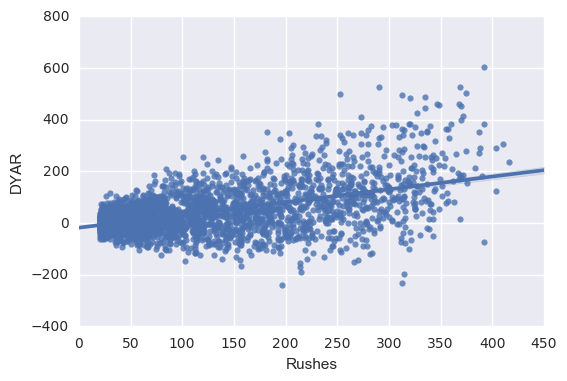

In [23]:
sns.regplot(rb_stats['Rushes'],rb_stats['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

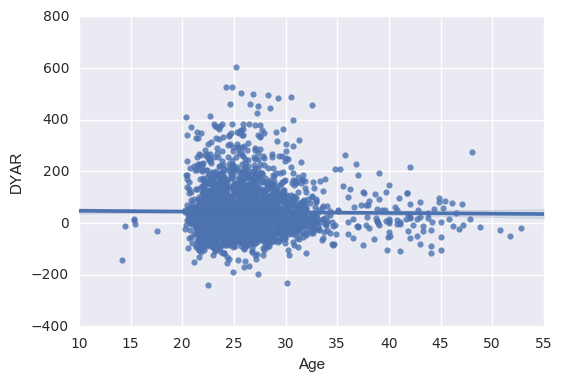

In [24]:
plt.figure(1)
sns.regplot(rb_stats['Age'],rb_stats['DYAR'], scatter= True, fit_reg=True, ci = 90)
plt.show()

In [36]:
rb_career_data = rb_stats[~pd.isnull(rb_stats['DYAR_-1'])]
rb_career_data['DYAR_diff'] = rb_career_data['DYAR'] - rb_career_data['DYAR_1']
rb_age_means = rb_career_data.groupby(pd.cut(rb_career_data['Age'],np.arange(22,35,1))).mean()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


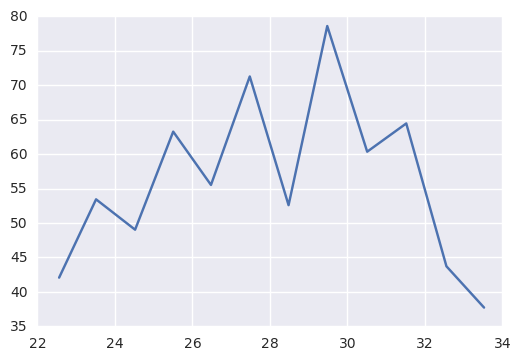

In [37]:
plt.figure(1)
plt.plot(rb_age_means['Age'],rb_age_means['DYAR'])
plt.show()

In [75]:
#Get rookie RBs
rook_rb = rb_stats[(pd.isnull(rb_stats['DYAR_1'])) & (rb_stats['Age'] < 23) & (rb_stats['Age'] > 18)]
#Drop RBs with no year 2
rook_rb.dropna(subset = ['DYAR_-1'], inplace = True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [101]:
from sklearn.cross_validation import train_test_split

rb_stats_mod = rb_stats[~pd.isnull(rb_stats['DYAR_-1'])]
features = rb_stats_mod[['DYAR','DVOA','Rushes','Suc_rate','Age']].values
labels = rb_stats_mod['DYAR_-1'].values

train_f, test_f, train_l, test_l = train_test_split(features, labels, test_size=0.20, random_state=42)

In [103]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(train_f,train_l)
model.score(test_f,test_l)

-0.088234589875067812

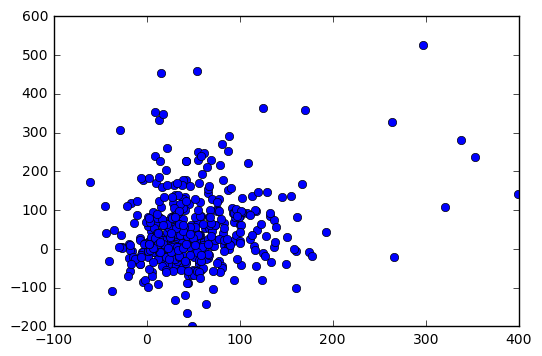

array([ 0.31341779,  0.16561972,  0.21778937,  0.09252722,  0.2106459 ])

In [104]:
plt.plot(model.predict(test_f),test_l,'ob')
plt.show()
model.feature_importances_

AttributeError: 'RandomForestRegressor' object has no attribute 'decision_path'